<a href="https://colab.research.google.com/github/SuminBae97/PytorchStudy/blob/main/3_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mxnet

In [ ]:
pip install --upgrade mxnet~=1.7 gluonts

In [10]:
from fbprophet import Prophet
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import json


<h1>Twitter time series data forecast</h1>
<h1>5분 frequency</h1>

In [5]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


<h1>dataset 호출</h1>
<h1>1시간의 시간간격 데이터</h1>

In [6]:
dataset = get_dataset('m4_hourly',regenerate=True)
train = list(dataset.train)
test = list(dataset.test)

saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


In [17]:
train_data = list(dataset.train)
test_data = list(dataset.test)

In [8]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive')
# #svae
# ar_predictor.serialize(Path('/content/gdrive/My Drive/Colab Notebooks/deepar/'))

# #load
from gluonts.model.predictor import Predictor
ar_predictor = Predictor.deserialize(Path('/content/gdrive/My Drive/Colab Notebooks/deepar/'))

Mounted at /content/gdrive


In [11]:
forecast_it,ts_it = make_evaluation_predictions(
    dataset = dataset.test,
    predictor = ar_predictor,
    num_samples=100
)

In [12]:
forecasts = list(forecast_it)
tss = list(ts_it)
evaluator = Evaluator(quantiles=[0.1,0.5,0.9])
agg_metrics ,item_metrics = evaluator(iter(tss),iter(forecasts),num_series=len(dataset.test))

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 15116.45it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq

In [ ]:
agg_metrics

In [40]:
from sklearn.metrics import mean_squared_error 
#mean_squared_error(y_test, y_pred)

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
i=0
print(f'{i}변째 time series mape:{MAPE(tss[i][700:].values.reshape(-1,) ,forecasts[i].median)}')
print(f'{i}변째 time series mse:{mean_squared_error(tss[i][700:].values.reshape(-1,) ,forecasts[i].median)}')


0변째 time series mape:3.6813855171203613
0변째 time series mse:1108.6842041015625


In [15]:
from fbprophet import Prophet

In [18]:
rng = pd.date_range('1750-01-01',periods=748,freq='H')
#test_data[i]에 따라 다르다
df = pd.DataFrame({ 'ds': rng, 'y': test_data[0]['target'] }) 
x_test = df[700:]
x_train=df[:700]

#modeling
m = Prophet()
m.fit(x_train)

#predicting
future = m.make_future_dataframe(periods=48,freq='H')
forecast = m.predict(future)

In [ ]:
prophet_models =[]
prophet_results = []
for i in range(len(train_data)):
    df = pd.DataFrame({ 'ds': rng, 'y': test_data[i]['target'] })
    x_train=df[:700]
    m = Prophet()
    m.fit(x_train)
    
    prophet_models.append(m)
    
    future = m.make_future_dataframe(periods=48,freq='H')
    forecast = m.predict(future)

    y_hat = forecast['yhat'][700:].values
    prophet_results.append(y_hat)


    



In [84]:
len(prophet_results)

169

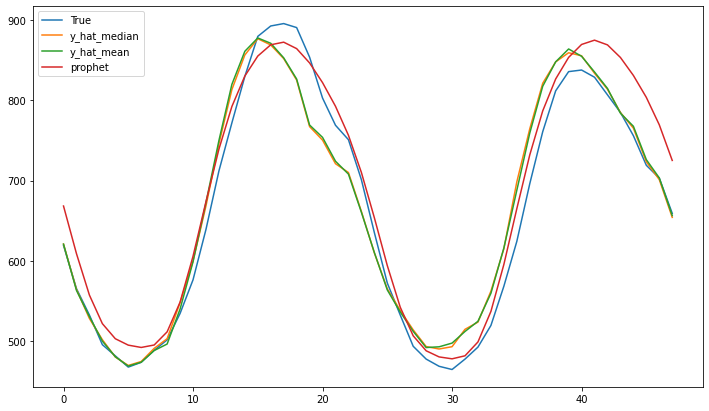

In [39]:
plt.figure(figsize=(12,7))
plt.plot(tss[0][700:].values.reshape(-1,),label='True')
plt.plot(forecasts[0].median,label='y_hat_median')
plt.plot(forecasts[0].mean,label='y_hat_mean')
plt.plot(forecast['yhat'][700:].values,label='prophet')
plt.legend()

In [51]:
i=0
print(f'{i}번째 time series mape:{MAPE(tss[i][700:].values.reshape(-1,) ,forecasts[i].median)}')
print(f'{i}번째 time series mse:{mean_squared_error(tss[i][700:].values.reshape(-1,) ,forecasts[i].median)}')

print("========================================================================================================================================")

prophet_mse = mean_squared_error(tss[i][700:].values.reshape(-1,) , forecast['yhat'][700:].values)
prophet_mape = MAPE(tss[i][700:].values.reshape(-1,) , forecast['yhat'][700:].values)

print(f'{i}번째 prophet time series mse:{prophet_mape}')
print(f'{i}번째 prohphet time series mape:{prophet_mse}')

0번째 time series mape:3.6813855171203613
0번째 time series mse:1108.6842041015625
0번째 prophet time series mse:4.116542484998382
0번째 prohphet time series mape:1134.5272277430424


In [63]:
i=4
print(f'{i}번째 time series mape:{MAPE(tss[i][700:].values.reshape(-1,) ,forecasts[i].median)}')
print(f'{i}번째 time series mse:{mean_squared_error(tss[i][700:].values.reshape(-1,) ,forecasts[i].median)}')

print("========================================================================================================================================")

prophet_mse = mean_squared_error(tss[i][700:].values.reshape(-1,) , prophet_results[i])
prophet_mape = MAPE(tss[i][700:].values.reshape(-1,) , prophet_results[i])

print(f'{i}번째 prophet time series mse:{prophet_mape}')
print(f'{i}번째 prohphet time series mape:{prophet_mse}')

4번째 time series mape:7.2279296815395355
4번째 time series mse:86822.3828125
4번째 prophet time series mse:9.101515067066801
4번째 prohphet time series mape:68908.07685503979


In [ ]:
deepar_mape_results=[]
prophet_mape_results=[]
for i in range(169):
    print(f'{i}번째 time series mape:{MAPE(tss[i][700:].values.reshape(-1,) ,forecasts[i].median)}')
    #deepar_mape_results.append(MAPE(tss[i][700:].values.reshape(-1,) ,forecasts[i].median))
    print(f'{i}번째 time series mse:{mean_squared_error(tss[i][700:].values.reshape(-1,) ,forecasts[i].median)}')
    prophet_mse = mean_squared_error(tss[i][700:].values.reshape(-1,) , prophet_results[i])
    prophet_mape = MAPE(tss[i][700:].values.reshape(-1,) , prophet_results[i])
    #prophet_mape_results.append(prophet_mape)
    #print(f'{i}번째 prophet time series mape:{prophet_mape}')
    #print(f'{i}번째 prohphet time series mse:{prophet_mse}')
    print("========================================================================================================================================")


In [86]:
sum(deepar_mape_results)/len(deepar_mape_results)

19.492855862047545

In [87]:
sum(prophet_mape_results)/len(prophet_mape_results)

45.37774943645529

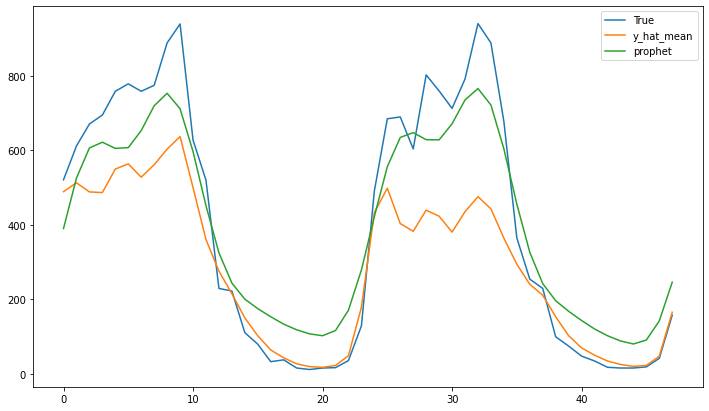

In [93]:
i=165

plt.figure(figsize=(12,7))
plt.plot(tss[i][700:].values.reshape(-1,),label='True')
#plt.plot(forecasts[i].median,label='y_hat_median')
plt.plot(forecasts[i].mean,label='y_hat_mean')
plt.plot(prophet_results[i],label='prophet')
plt.legend()